In [1]:
cd ~/Desktop/ML-Linear_regression/sgemm_product_dataset

/Users/Sujatha/Desktop/ML-Linear_regression/sgemm_product_dataset


In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.svm import SVC # "Support vector classifier"
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

## Data loading and preparation
1) GPU Kernel Data  
2) Spambase data (https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data)

(<matplotlib.axes._subplots.AxesSubplot at 0x11dd59590>, count    241600.000000
 mean        217.571953
 std         368.750161
 min          13.317500
 25%          40.667500
 50%          69.790000
 75%         228.387500
 max        3341.507500
 Name: avg_run, dtype: float64)

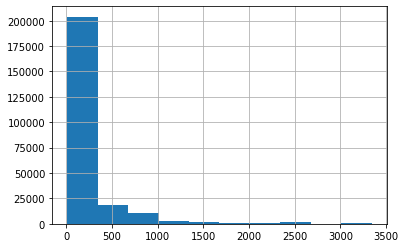

In [3]:
GPU_data = pd.read_csv("sgemm_product.csv")
GPU_data.columns = [c.replace(' ', '_') for c in GPU_data.columns] # space in col names are replaced by '_'

col = GPU_data.loc[ : ,"Run1_(ms)":"Run4_(ms)"]

GPU_data['avg_run'] = col.mean(axis = 1) # calculating avg run from the 4 runs

GPU_data = GPU_data.drop(["Run1_(ms)","Run2_(ms)", "Run3_(ms)", "Run4_(ms)"], axis=1)

GPU_data['avg_run'].hist(), GPU_data['avg_run'].describe()

In [4]:
## We will split the dataset in the median value. High speed run time are <= 69.79 (ms) target class '1' and low speed run time 
## are > 69.79 (ms) that is class '0'
GPU_data['Class'] =GPU_data['avg_run'].apply(lambda x: 1 if x <= 69.79 else 0)
GPU_data = GPU_data.drop(["avg_run"], axis = 1)
GPU_data["Class"].value_counts() ## balanced data

1    120801
0    120799
Name: Class, dtype: int64

In [5]:
## Splitting the dataset into 70% test and 30% train
GPU_train, GPU_test = train_test_split(GPU_data, test_size = 0.30, random_state = 123)
GPU_train.shape, GPU_test.shape

## Setting X and Y variable for the model
GPU_train_X = GPU_train.drop("Class", axis = 1)
GPU_train_Y = GPU_train["Class"]
GPU_test_X = GPU_test.drop("Class", axis = 1)
GPU_test_Y = GPU_test["Class"]

GPU_train_X.shape, GPU_train_Y.shape, GPU_test_X.shape, GPU_test_Y.shape

((169120, 14), (169120,), (72480, 14), (72480,))

#### Spambase data from UCI

In [6]:
spamdata = pd.read_csv("spamdata.csv")
spamdata

,Unnamed: 0,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spamflag
0,1,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,2,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,...,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,3,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,...,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,...,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,5,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,...,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,4597,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88,0
4597,4598,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14,0
4598,4599,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118,0
4599,4600,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,...,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78,0


In [7]:
spamdata.info(), spamdata.shape ## 59 columns with 4601 observations
spamdata = spamdata.drop(spamdata.columns[0], axis = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 59 columns):
Unnamed: 0                    4601 non-null int64
word_freq_make                4601 non-null float64
word_freq_address             4601 non-null float64
word_freq_all                 4601 non-null float64
word_freq_3d                  4601 non-null float64
word_freq_our                 4601 non-null float64
word_freq_over                4601 non-null float64
word_freq_remove              4601 non-null float64
word_freq_internet            4601 non-null float64
word_freq_order               4601 non-null float64
word_freq_mail                4601 non-null float64
word_freq_receive             4601 non-null float64
word_freq_will                4601 non-null float64
word_freq_people              4601 non-null float64
word_freq_report              4601 non-null float64
word_freq_addresses           4601 non-null float64
word_freq_free                4601 non-null float64
word_freq_b

In [8]:
print(spamdata["spamflag"].value_counts()) ## 60% are nonspam and 40% are spam, slightly imbalance which should be taken care in cross validation
spam = spamdata[spamdata["spamflag"] == 1]
nonspam = spamdata[spamdata["spamflag"] == 0]

0    2788
1    1813
Name: spamflag, dtype: int64


In [9]:
data0 = spam.mean(axis = 0)
data1 = nonspam.mean(axis = 0)
diff = data0 - data1
combine = pd.concat([data0, data1, diff], axis = 1, sort = True)
combine.rename(columns = {0:"spam", 1:"nonspam", 2:"diff"})

,spam,nonspam,diff
capital_run_length_average,9.519165,2.377301,7.141864
capital_run_length_longest,104.393271,18.214491,86.178780
capital_run_length_total,470.619415,161.470947,309.148468
char_freq_!,0.513713,0.109984,0.403729
char_freq_#,0.078877,0.021713,0.057164
char_freq_$,0.174478,0.011648,0.162830
char_freq_(,0.108970,0.158578,-0.049608
char_freq_;,0.020573,0.050281,-0.029708
char_freq_[,0.008199,0.022684,-0.014485
spamflag,1.000000,0.000000,1.000000


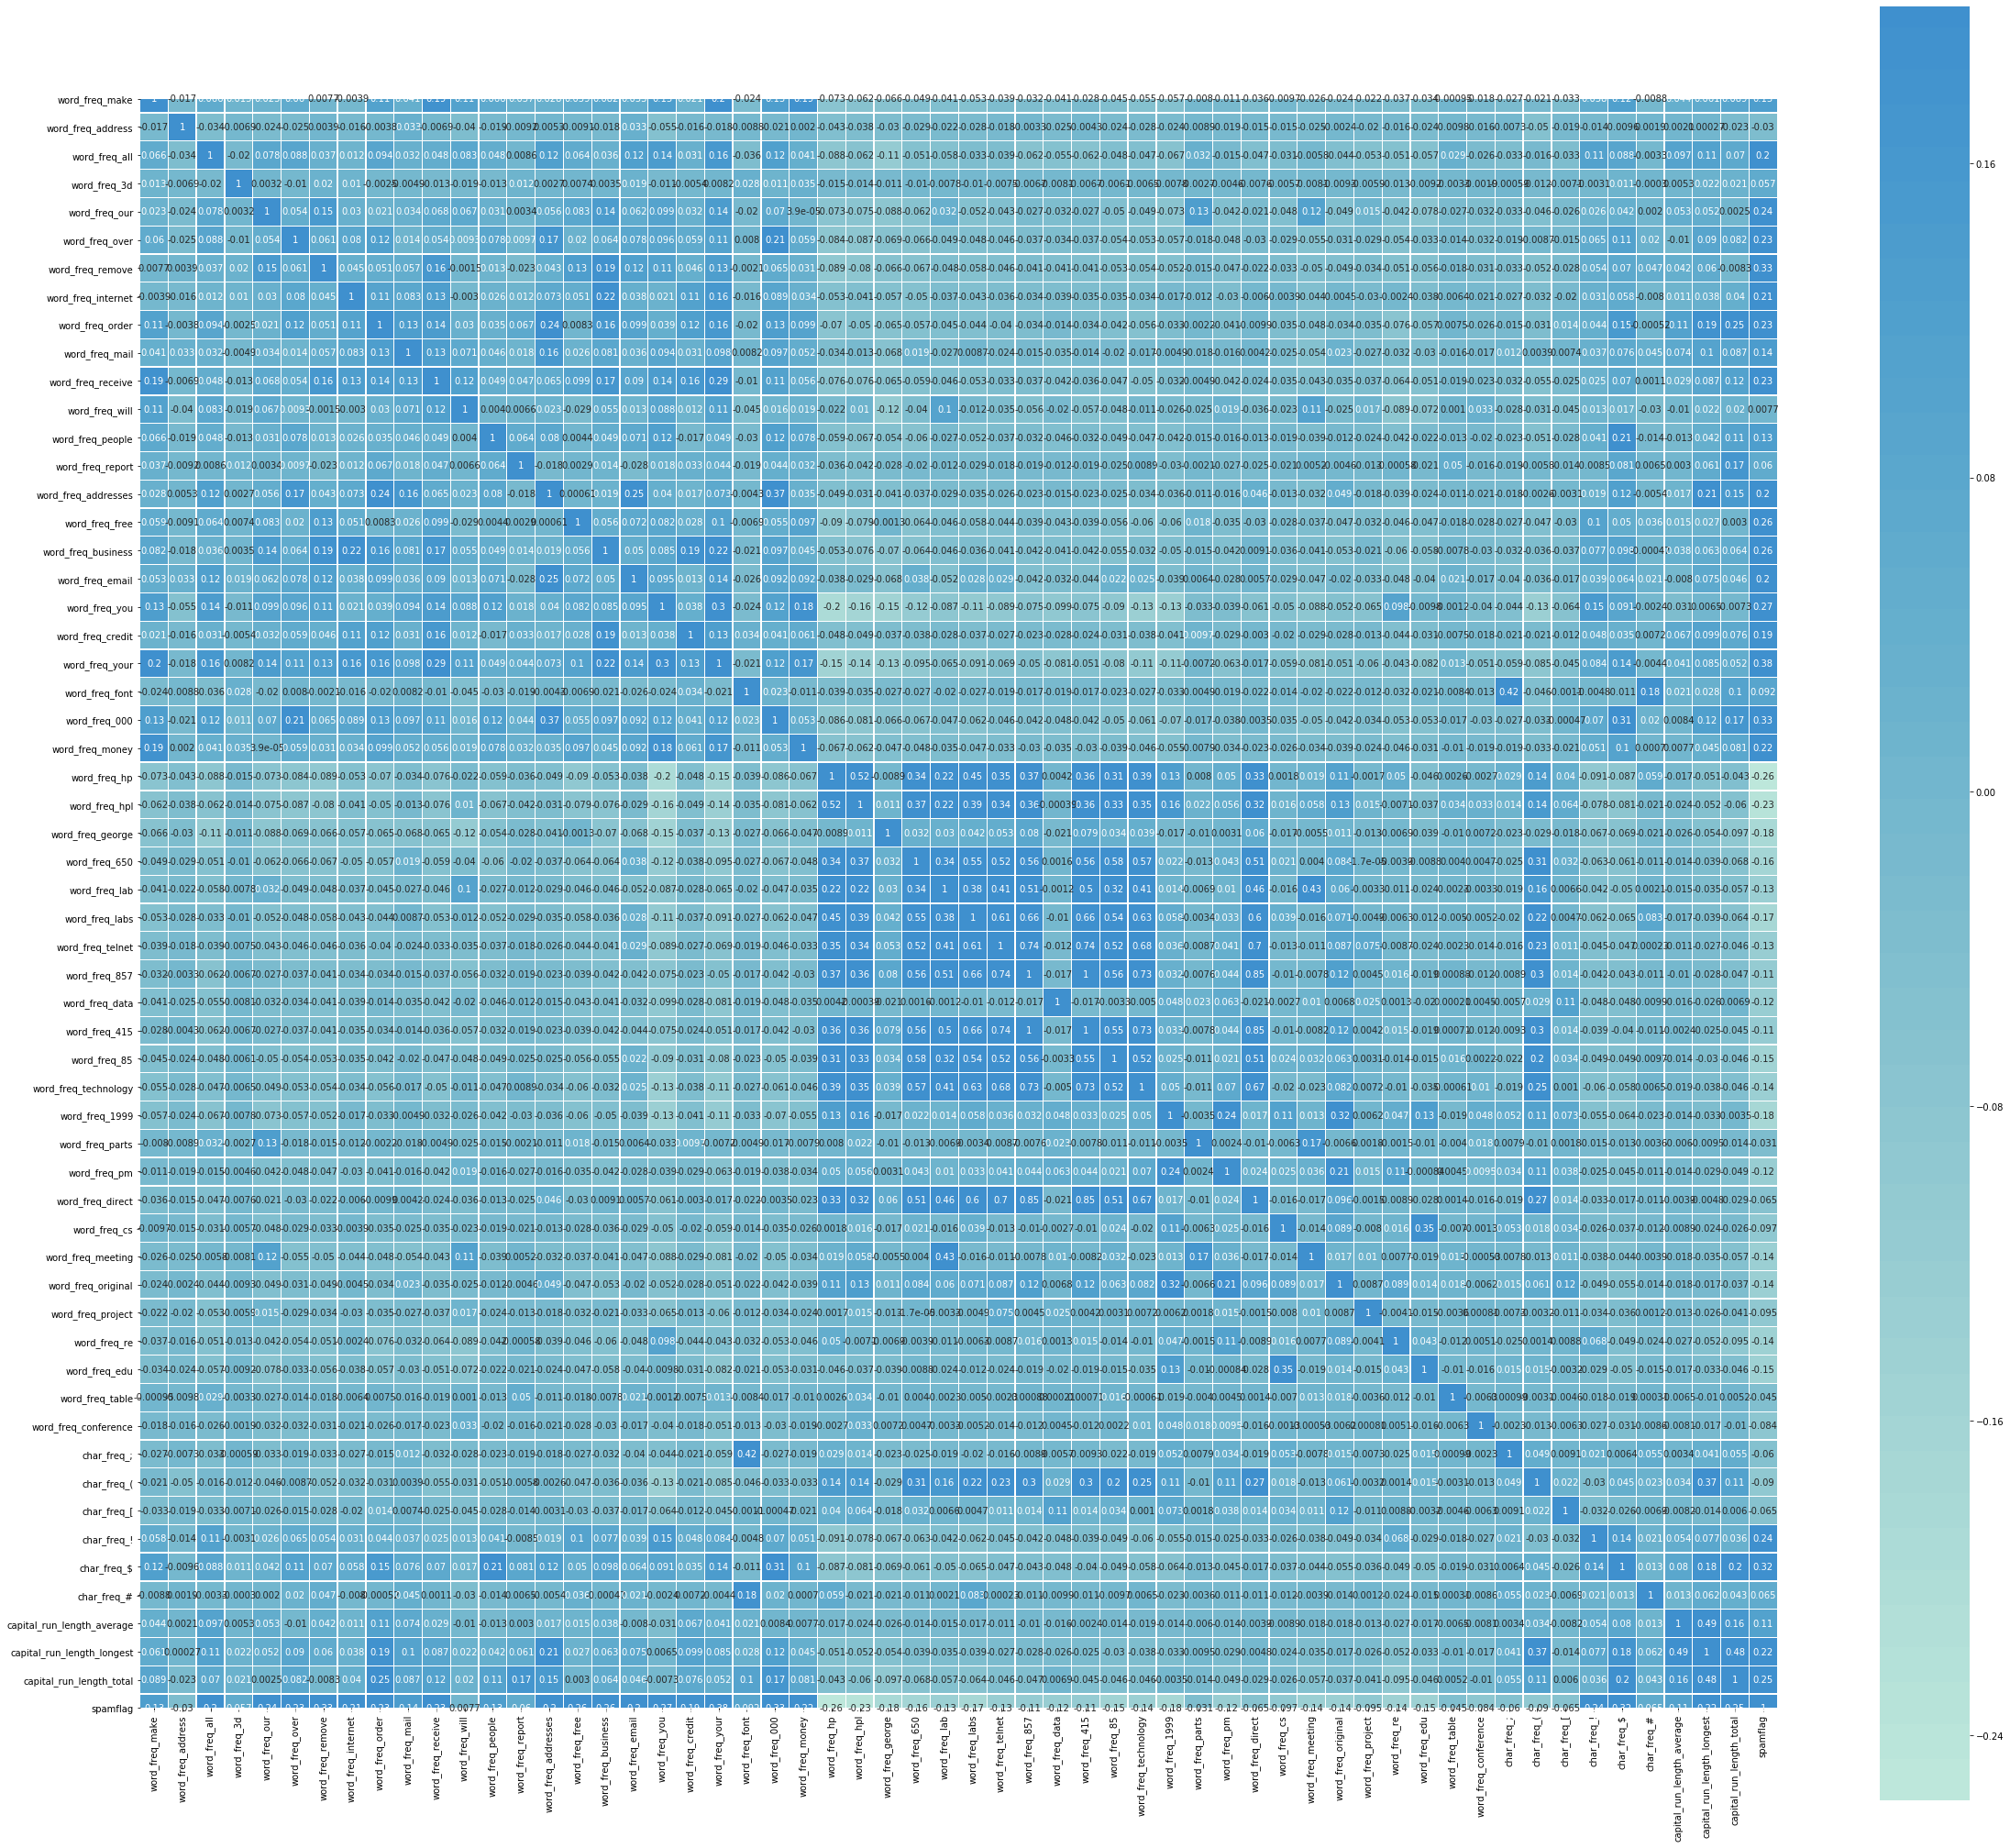

In [10]:
import seaborn as sn
corrMatrix = spamdata.corr()
f, ax = plt.subplots(figsize = (40,40))
sn.heatmap(corrMatrix, vmax=.2, center=1,
            square=True, linewidths=.3, cbar_kws={"shrink": .9}, annot = True, xticklabels = True, yticklabels = True)

In [11]:
## Splitting the dataset into 70% test and 30% train
spamdata = spamdata.sample(frac = 1, random_state = 12345)
spamdata_train, spamdata_test = train_test_split(spamdata, test_size = 0.30, random_state = 123)
spamdata_train.shape, spamdata_test.shape

## Setting X and Y variable for the model
spamdata_train_X = spamdata_train.drop("spamflag", axis = 1)
spamdata_train_Y = spamdata_train["spamflag"]
spamdata_test_X = spamdata_test.drop("spamflag", axis = 1)
spamdata_test_Y = spamdata_test["spamflag"]

spamdata_train_X.shape, spamdata_train_Y.shape, spamdata_test_X.shape, spamdata_test_Y.shape

((3220, 57), (3220,), (1381, 57), (1381,))

## Decision Tree 

### GPU_data

In [121]:
DT_model_1 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best') 
DT_model_1.fit(GPU_train_X, GPU_train_Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [122]:
test_predict_1 = DT_model_1.predict(GPU_test_X)

test_prob = DT_model_1.predict_proba(GPU_test_X)

print(confusion_matrix(GPU_test_Y, test_predict_1))
print(accuracy_score(GPU_test_Y, test_predict_1))

train_predict_1 = DT_model_1.predict(GPU_train_X)

print(confusion_matrix(GPU_train_Y, train_predict_1))
accuracy_score(GPU_train_Y, train_predict_1)

[[35996   313]
 [  335 35836]]
0.9910596026490066
[[84490     0]
 [    0 84630]]


1.0

In [27]:
print(DT_model_1.tree_.max_depth) ## roughly corresponds to 2500 leaf node

22


In [9]:
DT_model_2 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_leaf_nodes = 2000) 
DT_model_2.fit(GPU_train_X, GPU_train_Y)
print(DT_model_2.tree_.max_depth)

21


In [10]:
test_predict_2 = DT_model_2.predict(GPU_test_X)

test_prob = DT_model_2.predict_proba(GPU_test_X)

print(confusion_matrix(GPU_test_Y, test_predict_2))
print(accuracy_score(GPU_test_Y, test_predict_2))

train_predict_2 = DT_model_2.predict(GPU_train_X)

print(confusion_matrix(GPU_train_Y, train_predict_2))
accuracy_score(GPU_train_Y, train_predict_2)

[[35809   500]
 [  279 35892]]
0.9892522075055188
[[83936   554]
 [  217 84413]]


0.9954411069063387

In [31]:
DT_model_3 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_leaf_nodes = 1000) 
DT_model_3.fit(GPU_train_X, GPU_train_Y)

test_predict_3 = DT_model_3.predict(GPU_test_X)

test_prob = DT_model_3.predict_proba(GPU_test_X)

print(confusion_matrix(GPU_test_Y, test_predict_3))
print(accuracy_score(GPU_test_Y, test_predict_3))

train_predict_3 = DT_model_3.predict(GPU_train_X)

print(confusion_matrix(GPU_train_Y, train_predict_3))
print(accuracy_score(GPU_train_Y, train_predict_3))

print(DT_model_3.tree_.max_depth)

[[35456   853]
 [  372 35799]]
0.9830987858719646
[[83078  1412]
 [  615 84015]]
0.9880144276253547
18


In [32]:
DT_model_4 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_leaf_nodes = 500) 
DT_model_4.fit(GPU_train_X, GPU_train_Y)

test_predict_4 = DT_model_4.predict(GPU_test_X)

test_prob = DT_model_4.predict_proba(GPU_test_X)

print(confusion_matrix(GPU_test_Y, test_predict_4))
print(accuracy_score(GPU_test_Y, test_predict_4))

train_predict_4 = DT_model_4.predict(GPU_train_X)

print(confusion_matrix(GPU_train_Y, train_predict_4))
print(accuracy_score(GPU_train_Y, train_predict_4))

print(DT_model_4.tree_.max_depth)

[[35068  1241]
 [  568 35603]]
0.9750413907284768
[[81933  2557]
 [ 1163 83467]]
0.978003784295175
16


In [33]:
DT_model_5 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_leaf_nodes = 250) 
DT_model_5.fit(GPU_train_X, GPU_train_Y)

test_predict_5 = DT_model_5.predict(GPU_test_X)

test_prob = DT_model_5.predict_proba(GPU_test_X)

print(confusion_matrix(GPU_test_Y, test_predict_5))
print(accuracy_score(GPU_test_Y, test_predict_5))

train_predict_5 = DT_model_5.predict(GPU_train_X)

print(confusion_matrix(GPU_train_Y, train_predict_5))
print(accuracy_score(GPU_train_Y, train_predict_5))

print(DT_model_5.tree_.max_depth)

[[34321  1988]
 [  804 35367]]
0.9614790286975717
[[80158  4332]
 [ 1777 82853]]
0.9638777199621571
14


In [34]:
DT_model_6 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_leaf_nodes = 125) 
DT_model_6.fit(GPU_train_X, GPU_train_Y)

test_predict_6 = DT_model_6.predict(GPU_test_X)

test_prob = DT_model_6.predict_proba(GPU_test_X)

print(confusion_matrix(GPU_test_Y, test_predict_6))
print(accuracy_score(GPU_test_Y, test_predict_6))

train_predict_6 = DT_model_6.predict(GPU_train_X)

print(confusion_matrix(GPU_train_Y, train_predict_6))
print(accuracy_score(GPU_train_Y, train_predict_6))

print(DT_model_6.tree_.max_depth)

[[33284  3025]
 [ 1005 35166]]
0.9443984547461368
[[77684  6806]
 [ 2235 82395]]
0.94654091769158
12


In [35]:
DT_model_7 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_leaf_nodes = 65) 
DT_model_7.fit(GPU_train_X, GPU_train_Y)

test_predict_7 = DT_model_7.predict(GPU_test_X)

test_prob = DT_model_7.predict_proba(GPU_test_X)

print(confusion_matrix(GPU_test_Y, test_predict_7))
print(accuracy_score(GPU_test_Y, test_predict_7))

train_predict_7 = DT_model_7.predict(GPU_train_X)

print(confusion_matrix(GPU_train_Y, train_predict_7))
print(accuracy_score(GPU_train_Y, train_predict_7))

print(DT_model_7.tree_.max_depth)

[[31463  4846]
 [ 1333 34838]]
0.9147488962472407
[[73577 10913]
 [ 2987 81643]]
0.9178098391674551
10


In [36]:
DT_model_8 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_leaf_nodes = 30) 
DT_model_8.fit(GPU_train_X, GPU_train_Y)

test_predict_8 = DT_model_8.predict(GPU_test_X)

test_prob = DT_model_8.predict_proba(GPU_test_X)

print(confusion_matrix(GPU_test_Y, test_predict_8))
print(accuracy_score(GPU_test_Y, test_predict_8))

train_predict_8 = DT_model_8.predict(GPU_train_X)

print(confusion_matrix(GPU_train_Y, train_predict_8))
print(accuracy_score(GPU_train_Y, train_predict_8))

print(DT_model_8.tree_.max_depth)

[[28589  7720]
 [ 2046 34125]]
0.8652593818984547
[[66789 17701]
 [ 4448 80182]]
0.8690338221381267
8


In [37]:
DT_model_9 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_leaf_nodes = 15) 
DT_model_9.fit(GPU_train_X, GPU_train_Y)

test_predict_9 = DT_model_9.predict(GPU_test_X)

test_prob = DT_model_9.predict_proba(GPU_test_X)

print(confusion_matrix(GPU_test_Y, test_predict_9))
print(accuracy_score(GPU_test_Y, test_predict_9))

train_predict_9 = DT_model_9.predict(GPU_train_X)

print(confusion_matrix(GPU_train_Y, train_predict_9))
print(accuracy_score(GPU_train_Y, train_predict_9))

print(DT_model_9.tree_.max_depth)

[[24601 11708]
 [ 2746 33425]]
0.8005794701986755
[[57342 27148]
 [ 6207 78423]]
0.8027731788079471
6


In [18]:
DT_model_10 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_leaf_nodes = 8) 
DT_model_10.fit(GPU_train_X, GPU_train_Y)

test_predict_10 = DT_model_10.predict(GPU_test_X)

test_prob = DT_model_10.predict_proba(GPU_test_X)

print(confusion_matrix(GPU_test_Y, test_predict_10))
print(accuracy_score(GPU_test_Y, test_predict_10))

train_predict_10 = DT_model_10.predict(GPU_train_X)

print(confusion_matrix(GPU_train_Y, train_predict_10))
print(accuracy_score(GPU_train_Y, train_predict_10))

print(DT_model_10.tree_.max_depth)

[[26946  9363]
 [ 7301 28870]]
0.7700883002207506
[[62776 21714]
 [16801 67829]]
0.7722622989593189
5


[Text(182.61818181818182, 199.32, 'X[0] <= 96.0\ngini = 0.5\nsamples = 169120\nvalue = [84490, 84630]'),
 Text(91.30909090909091, 163.07999999999998, 'X[1] <= 96.0\ngini = 0.442\nsamples = 99153\nvalue = [32689, 66464]'),
 Text(60.872727272727275, 126.83999999999999, 'gini = 0.366\nsamples = 58163\nvalue = [14035, 44128]'),
 Text(121.74545454545455, 126.83999999999999, 'X[4] <= 12.0\ngini = 0.496\nsamples = 40990\nvalue = [18654, 22336]'),
 Text(91.30909090909091, 90.6, 'X[3] <= 24.0\ngini = 0.454\nsamples = 19344\nvalue = [12617, 6727]'),
 Text(60.872727272727275, 54.359999999999985, 'X[0] <= 48.0\ngini = 0.36\nsamples = 16215\nvalue = [12396, 3819]'),
 Text(30.436363636363637, 18.119999999999976, 'gini = 0.499\nsamples = 7912\nvalue = [4093, 3819]'),
 Text(91.30909090909091, 18.119999999999976, 'gini = 0.0\nsamples = 8303\nvalue = [8303, 0]'),
 Text(121.74545454545455, 54.359999999999985, 'gini = 0.131\nsamples = 3129\nvalue = [221, 2908]'),
 Text(152.1818181818182, 90.6, 'gini = 0.4

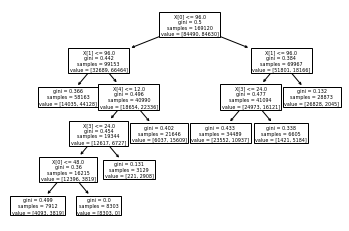

In [20]:
tree.plot_tree(DT_model_10.fit(GPU_train_X, GPU_train_Y))

<Figure size 720x720 with 0 Axes>

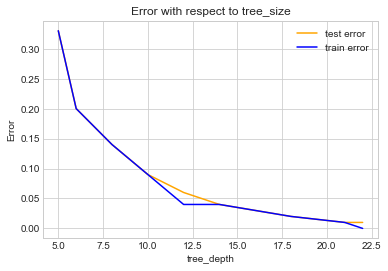

<Figure size 720x720 with 0 Axes>

In [17]:
## Tree size vs error plot
test_error = np.array([0.33, 0.20, 0.14, 0.09, 0.06, 0.04, 0.03, 0.02, 0.01, 0.01])
train_error = np.array([0.33, 0.20, 0.14, 0.09, 0.04, 0.04, 0.03, 0.02, 0.01, 0])
tree_size = np.array([5, 6, 8, 10, 12, 14, 16, 18, 21, 22])
plt.style.use('seaborn-whitegrid')
plt.plot(tree_size, test_error, color = 'orange')
plt.plot(tree_size, train_error, color = 'blue')
plt.title("Error with respect to tree_size")
plt.ylabel("Error")
plt.xlabel("tree_depth")
plt.legend(["test error", "train error"], loc = 'upper right')
plt.figure(figsize = (10,10))

In [30]:
## model with CV 10 fold
CV_model_10 = cross_val_score(DT_model_10, GPU_train_X, GPU_train_Y, cv = 5)
print("For tree depth 5: ", CV_model_10)

CV_model_9 = cross_val_score(DT_model_9, GPU_train_X, GPU_train_Y, cv = 5)
print("For tree depth 6: ", CV_model_9)

CV_model_8 = cross_val_score(DT_model_8, GPU_train_X, GPU_train_Y, cv = 5)
print("For tree depth 8: ", CV_model_8)

CV_model_7 = cross_val_score(DT_model_7, GPU_train_X, GPU_train_Y, cv = 5)
print("For tree depth 10: ", CV_model_7)

CV_model_6 = cross_val_score(DT_model_6, GPU_train_X, GPU_train_Y, cv = 5)
print("For tree depth 12: ", CV_model_6)

CV_model_5 = cross_val_score(DT_model_5, GPU_train_X, GPU_train_Y, cv = 5)
print("For tree depth 14: ", CV_model_5)

CV_model_4 = cross_val_score(DT_model_4, GPU_train_X, GPU_train_Y, cv = 5)
print("For tree depth 16: ", CV_model_4)

CV_model_3 = cross_val_score(DT_model_3, GPU_train_X, GPU_train_Y, cv = 5)
print("For tree depth 18: ", CV_model_3)

CV_model_2 = cross_val_score(DT_model_2, GPU_train_X, GPU_train_Y, cv = 5)
print("For tree depth 21: ", CV_model_2)

CV_model_1 = cross_val_score(DT_model_1, GPU_train_X, GPU_train_Y, cv = 5)
print("For tree depth 22: ", CV_model_1)

For tree depth 5:  [0.77090232 0.77243969 0.77379967 0.77311968 0.77105014]
For tree depth 6:  [0.81087394 0.80638009 0.80785833 0.80516793 0.80303926]
For tree depth 8:  [0.87467479 0.8702992  0.86749054 0.86855487 0.87195482]
For tree depth 10:  [0.91854896 0.92289499 0.91775071 0.92100284 0.92381149]
For tree depth 12:  [0.9453938  0.94832072 0.94530511 0.94574858 0.94764073]
For tree depth 14:  [0.96224574 0.96189096 0.9618614  0.96147706 0.96268921]
For tree depth 16:  [0.97510643 0.97481079 0.97741249 0.97413079 0.97631859]
For tree depth 18:  [0.984715   0.98288198 0.98580889 0.98326632 0.98415326]
For tree depth 21:  [0.98926798 0.98917928 0.98912015 0.98829234 0.98909059]
For tree depth 22:  [0.98956362 0.98900189 0.98974101 0.98909059 0.98867668]


<Figure size 720x720 with 0 Axes>

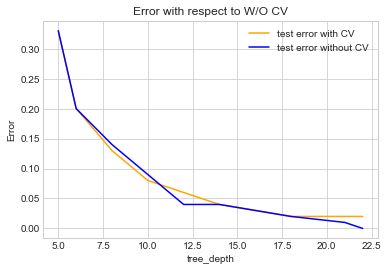

<Figure size 720x720 with 0 Axes>

In [18]:
W_cv_error = np.array([0.33, 0.20, 0.13, 0.08, 0.06, 0.04, 0.03, 0.02, 0.02, 0.02])
WO_cv_error = np.array([0.33, 0.20, 0.14, 0.09, 0.04, 0.04, 0.03, 0.02, 0.01, 0])
tree_size = np.array([5, 6, 8, 10, 12, 14, 16, 18, 21, 22])
plt.style.use('seaborn-whitegrid')
plt.plot(tree_size, W_cv_error, color = 'orange')
plt.plot(tree_size, WO_cv_error, color = 'blue')
plt.title("Error with respect to W/O CV")
plt.ylabel("Error")
plt.xlabel("tree_depth")
plt.legend(["test error with CV", "test error without CV"], loc = 'upper right')
plt.figure(figsize = (10,10))

### Spambase data

In [19]:
DT_spamdata_1 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best') 
DT_spamdata_1.fit(spamdata_train_X, spamdata_train_Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [20]:
sptest_predict_1 = DT_spamdata_1.predict(spamdata_test_X)

sptest_prob = DT_spamdata_1.predict_proba(spamdata_test_X)

print(confusion_matrix(spamdata_test_Y, sptest_predict_1))
print(accuracy_score(spamdata_test_Y, sptest_predict_1))

sptrain_predict_1 = DT_spamdata_1.predict(spamdata_train_X)

print(confusion_matrix(spamdata_train_Y, sptrain_predict_1))
accuracy_score(spamdata_train_Y, sptrain_predict_1)

[[753  69]
 [ 54 505]]
0.9109341057204924
[[1966    0]
 [   0 1254]]


1.0

23


[Text(279.8767707101582, 212.91, 'X[52] <= 0.056\ngini = 0.476\nsamples = 3220\nvalue = [1966, 1254]'),
 Text(237.2722076340254, 203.85, 'X[6] <= 0.065\ngini = 0.355\nsamples = 2440\nvalue = [1877, 563]'),
 Text(186.77932262948494, 194.79, 'X[51] <= 0.191\ngini = 0.269\nsamples = 2209\nvalue = [1856, 353]'),
 Text(148.3667775923119, 185.73, 'X[15] <= 0.04\ngini = 0.151\nsamples = 1788\nvalue = [1641, 147]'),
 Text(124.73592798625447, 176.67, 'X[54] <= 22.188\ngini = 0.11\nsamples = 1605\nvalue = [1511, 94]'),
 Text(108.97081852509996, 167.60999999999999, 'X[24] <= 0.015\ngini = 0.106\nsamples = 1600\nvalue = [1510, 90]'),
 Text(84.15987208299579, 158.55, 'X[55] <= 10.5\ngini = 0.158\nsamples = 1004\nvalue = [917, 87]'),
 Text(60.995114589594166, 149.49, 'X[7] <= 0.25\ngini = 0.075\nsamples = 694\nvalue = [667, 27]'),
 Text(49.241855907178504, 140.43, 'X[23] <= 10.795\ngini = 0.057\nsamples = 680\nvalue = [660, 20]'),
 Text(47.002098413776885, 131.37, 'X[4] <= 7.415\ngini = 0.054\nsampl

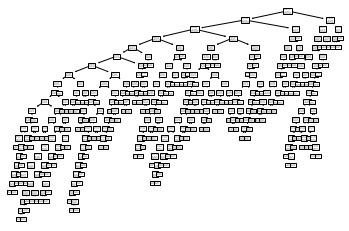

In [125]:
print(DT_spamdata_1.tree_.max_depth)
tree.plot_tree(DT_spamdata_1.fit(spamdata_train_X, spamdata_train_Y))

In [27]:
## Experiment with pruning
DT_spamdata_2 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_leaf_nodes = 1000) 
DT_spamdata_2.fit(spamdata_train_X, spamdata_train_Y)
sptest_predict_2 = DT_spamdata_2.predict(spamdata_test_X)
sptest_prob = DT_spamdata_2.predict_proba(spamdata_test_X)
print(confusion_matrix(spamdata_test_Y, sptest_predict_2))
print(accuracy_score(spamdata_test_Y, sptest_predict_2))
sptrain_predict_2 = DT_spamdata_2.predict(spamdata_train_X)
print(confusion_matrix(spamdata_train_Y, sptrain_predict_2))
print(accuracy_score(spamdata_train_Y, sptrain_predict_2))
print(DT_spamdata_2.tree_.max_depth)

DT_spamdata_3 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_leaf_nodes = 100) 
DT_spamdata_3.fit(spamdata_train_X, spamdata_train_Y)
sptest_predict_3 = DT_spamdata_3.predict(spamdata_test_X)
sptest_prob = DT_spamdata_3.predict_proba(spamdata_test_X)
print(confusion_matrix(spamdata_test_Y, sptest_predict_3))
print(accuracy_score(spamdata_test_Y, sptest_predict_3))
sptrain_predict_3 = DT_spamdata_3.predict(spamdata_train_X)
print(confusion_matrix(spamdata_train_Y, sptrain_predict_3))
print(accuracy_score(spamdata_train_Y, sptrain_predict_3))
print(DT_spamdata_3.tree_.max_depth)

DT_spamdata_4 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_leaf_nodes = 50) 
DT_spamdata_4.fit(spamdata_train_X, spamdata_train_Y)
sptest_predict_4 = DT_spamdata_4.predict(spamdata_test_X)
sptest_prob = DT_spamdata_4.predict_proba(spamdata_test_X)
print(confusion_matrix(spamdata_test_Y, sptest_predict_4))
print(accuracy_score(spamdata_test_Y, sptest_predict_4))
sptrain_predict_4 = DT_spamdata_4.predict(spamdata_train_X)
print(confusion_matrix(spamdata_train_Y, sptrain_predict_4))
print(accuracy_score(spamdata_train_Y, sptrain_predict_4))
print(DT_spamdata_4.tree_.max_depth)

DT_spamdata_5 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_leaf_nodes = 25) 
DT_spamdata_5.fit(spamdata_train_X, spamdata_train_Y)
sptest_predict_5 = DT_spamdata_5.predict(spamdata_test_X)
sptest_prob = DT_spamdata_5.predict_proba(spamdata_test_X)
print(confusion_matrix(spamdata_test_Y, sptest_predict_5))
print(accuracy_score(spamdata_test_Y, sptest_predict_5))
sptrain_predict_5 = DT_spamdata_5.predict(spamdata_train_X)
print(confusion_matrix(spamdata_train_Y, sptrain_predict_5))
print(accuracy_score(spamdata_train_Y, sptrain_predict_5))
print(DT_spamdata_5.tree_.max_depth)

DT_spamdata_6 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_leaf_nodes = 12) 
DT_spamdata_6.fit(spamdata_train_X, spamdata_train_Y)
sptest_predict_6 = DT_spamdata_6.predict(spamdata_test_X)
sptest_prob = DT_spamdata_6.predict_proba(spamdata_test_X)
print(confusion_matrix(spamdata_test_Y, sptest_predict_6))
print(accuracy_score(spamdata_test_Y, sptest_predict_6))
sptrain_predict_6 = DT_spamdata_6.predict(spamdata_train_X)
print(confusion_matrix(spamdata_train_Y, sptrain_predict_6))
print(accuracy_score(spamdata_train_Y, sptrain_predict_6))
print(DT_spamdata_6.tree_.max_depth)

DT_spamdata_7 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_leaf_nodes = 6) 
DT_spamdata_7.fit(spamdata_train_X, spamdata_train_Y)
sptest_predict_7 = DT_spamdata_7.predict(spamdata_test_X)
sptest_prob = DT_spamdata_7.predict_proba(spamdata_test_X)
print(confusion_matrix(spamdata_test_Y, sptest_predict_7))
print(accuracy_score(spamdata_test_Y, sptest_predict_7))
sptrain_predict_7 = DT_spamdata_7.predict(spamdata_train_X)
print(confusion_matrix(spamdata_train_Y, sptrain_predict_7))
print(accuracy_score(spamdata_train_Y, sptrain_predict_7))
print(DT_spamdata_7.tree_.max_depth)

DT_spamdata_8 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_leaf_nodes = 3) 
DT_spamdata_8.fit(spamdata_train_X, spamdata_train_Y)
sptest_predict_8 = DT_spamdata_8.predict(spamdata_test_X)
sptest_prob = DT_spamdata_8.predict_proba(spamdata_test_X)
print(confusion_matrix(spamdata_test_Y, sptest_predict_8))
print(accuracy_score(spamdata_test_Y, sptest_predict_8))
sptrain_predict_8 = DT_spamdata_8.predict(spamdata_train_X)
print(confusion_matrix(spamdata_train_Y, sptrain_predict_8))
print(accuracy_score(spamdata_train_Y, sptrain_predict_8))
print(DT_spamdata_8.tree_.max_depth)

[[761  61]
 [ 56 503]]
0.9152787834902245
[[1966    0]
 [   0 1254]]
1.0
23
[[770  52]
 [ 52 507]]
0.9246922519913107
[[1946   20]
 [  43 1211]]
0.9804347826086957
20
[[761  61]
 [ 45 514]]
0.9232440260680667
[[1895   71]
 [  61 1193]]
0.9590062111801242
14
[[792  30]
 [ 80 479]]
0.9203475742215785
[[1912   54]
 [ 162 1092]]
0.9329192546583851
9
[[786  36]
 [ 92 467]]
0.9073135409123824
[[1893   73]
 [ 198 1056]]
0.9158385093167701
6
[[773  49]
 [105 454]]
0.88848660391021
[[1868   98]
 [ 226 1028]]
0.8993788819875776
4
[[769  53]
 [164 395]]
0.8428674873280232
[[1856  110]
 [ 353  901]]
0.8562111801242236
2


<Figure size 720x720 with 0 Axes>

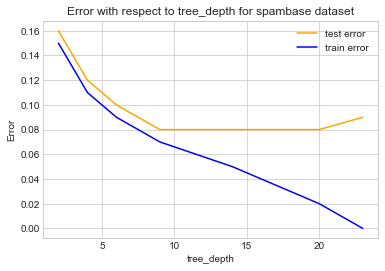

<Figure size 720x720 with 0 Axes>

In [30]:
train_error = np.array([0.15, 0.11, 0.09, 0.07, 0.05, 0.02, 0])
test_error = np.array([0.16,0.12, 0.10, 0.08, 0.08, 0.08, 0.09 ])
tree_depth = np.array([2,4,6,9,14,20,23])
plt.style.use('seaborn-whitegrid')
plt.plot(tree_depth, test_error, color = 'orange')
plt.plot(tree_depth, train_error, color = 'blue')
plt.title("Error with respect to tree_depth for spambase dataset")
plt.ylabel("Error")
plt.xlabel("tree_depth")
plt.legend(["test error", "train error"], loc = 'upper right')
plt.figure(figsize = (10,10))

In [38]:
## model with CV 10 fold
CV_model_8 = cross_val_score(DT_spamdata_8, spamdata_train_X, spamdata_train_Y, cv = 5)
print("For tree depth 5: ", CV_model_8)

CV_model_7 = cross_val_score(DT_spamdata_7, spamdata_train_X, spamdata_train_Y, cv = 5)
print("For tree depth 10: ", CV_model_7)

CV_model_6 = cross_val_score(DT_spamdata_6, spamdata_train_X, spamdata_train_Y, cv = 5)
print("For tree depth 12: ", CV_model_6)

CV_model_5 = cross_val_score(DT_spamdata_5, spamdata_train_X, spamdata_train_Y, cv = 5)
print("For tree depth 14: ", CV_model_5)

CV_model_4 = cross_val_score(DT_spamdata_4, spamdata_train_X, spamdata_train_Y, cv = 5)
print("For tree depth 16: ", CV_model_4)

CV_model_3 = cross_val_score(DT_spamdata_3, spamdata_train_X, spamdata_train_Y, cv = 5)
print("For tree depth 18: ", CV_model_3)

CV_model_2 = cross_val_score(DT_spamdata_2, spamdata_train_X, spamdata_train_Y, cv = 5)
print("For tree depth 21: ", CV_model_2)

CV_model_1 = cross_val_score(DT_spamdata_1, spamdata_train_X, spamdata_train_Y, cv = 5)
print("For tree depth 22: ", CV_model_1)

For tree depth 5:  [0.84651163 0.80279503 0.80124224 0.8431677  0.84914463]
For tree depth 10:  [0.89457364 0.86801242 0.86490683 0.88664596 0.90824261]
For tree depth 12:  [0.89302326 0.90062112 0.88975155 0.91770186 0.91757387]
For tree depth 14:  [0.91472868 0.91304348 0.90372671 0.90993789 0.91446345]
For tree depth 16:  [0.92248062 0.92080745 0.90838509 0.90993789 0.92068429]
For tree depth 18:  [0.93023256 0.91304348 0.89906832 0.90993789 0.92068429]
For tree depth 21:  [0.91937984 0.9068323  0.88819876 0.90838509 0.90824261]
For tree depth 22:  [0.91472868 0.90062112 0.88354037 0.91149068 0.90202177]


<Figure size 720x720 with 0 Axes>

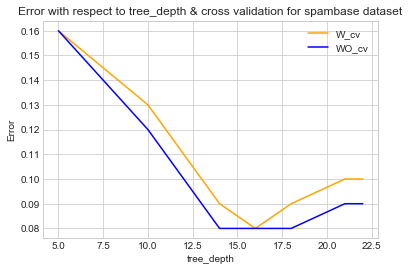

<Figure size 720x720 with 0 Axes>

In [42]:
tree_depth = np.array([5,10,12,14,16,18,21,22])
w_cv_error = np.array([0.16, 0.13, 0.11, 0.09, 0.08, 0.09, 0.10, 0.10])
Wo_cv_error = np.array([0.16,0.12, 0.10, 0.08, 0.08, 0.08, 0.09, 0.09 ])
plt.style.use('seaborn-whitegrid')
plt.plot(tree_depth, w_cv_error, color = 'orange')
plt.plot(tree_depth, Wo_cv_error, color = 'blue')
plt.title("Error with respect to tree_depth & cross validation for spambase dataset")
plt.legend(["W_cv", "WO_cv"], loc = 'upper right')
plt.ylabel("Error")
plt.xlabel("tree_depth")
plt.figure(figsize = (10,10))

## Boosting 

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

In [36]:
GBC_model_1 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
GBC_model_1.fit(GPU_train_X, GPU_train_Y)

print("train accuracy: ", GBC_model_1.score(GPU_train_X, GPU_train_Y))
print("test accuracy: ", GBC_model_1.score(GPU_test_X, GPU_test_Y))

## learning_rate is a hyper-parameter in the range (0.0, 1.0] that controls overfitting via shrinkage 

train accuracy:  0.8256385998107852
test accuracy:  0.8198399558498897


In [44]:
from sklearn.model_selection import GridSearchCV
param_grid = { 'n_estimators' : [20, 40, 60, 80, 100], 'learning_rate': [0.1, 0.02, 0.005, 0.5]}
grid1 = GridSearchCV(GradientBoostingClassifier(max_depth = 10, min_samples_leaf=50,max_features='sqrt'),param_grid,refit=True,verbose=2, cv = 5)
grid1.fit(GPU_train_X, GPU_train_Y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] learning_rate=0.1, n_estimators=20 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... learning_rate=0.1, n_estimators=20, total=  13.0s
[CV] learning_rate=0.1, n_estimators=20 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s remaining:    0.0s


[CV] ............... learning_rate=0.1, n_estimators=20, total=  13.1s
[CV] learning_rate=0.1, n_estimators=20 ..............................
[CV] ............... learning_rate=0.1, n_estimators=20, total=  13.1s
[CV] learning_rate=0.1, n_estimators=20 ..............................
[CV] ............... learning_rate=0.1, n_estimators=20, total=  13.7s
[CV] learning_rate=0.1, n_estimators=20 ..............................
[CV] ............... learning_rate=0.1, n_estimators=20, total=  31.3s
[CV] learning_rate=0.1, n_estimators=40 ..............................
[CV] ............... learning_rate=0.1, n_estimators=40, total=  34.4s
[CV] learning_rate=0.1, n_estimators=40 ..............................
[CV] ............... learning_rate=0.1, n_estimators=40, total=  41.5s
[CV] learning_rate=0.1, n_estimators=40 ..............................
[CV] ............... learning_rate=0.1, n_estimators=40, total=  29.2s
[CV] learning_rate=0.1, n_estimators=40 ..............................
[CV] .

[CV] ............. learning_rate=0.005, n_estimators=40, total=  33.4s
[CV] learning_rate=0.005, n_estimators=60 ............................
[CV] ............. learning_rate=0.005, n_estimators=60, total=  43.2s
[CV] learning_rate=0.005, n_estimators=60 ............................
[CV] ............. learning_rate=0.005, n_estimators=60, total=  43.2s
[CV] learning_rate=0.005, n_estimators=60 ............................
[CV] ............. learning_rate=0.005, n_estimators=60, total=  44.1s
[CV] learning_rate=0.005, n_estimators=60 ............................
[CV] ............. learning_rate=0.005, n_estimators=60, total=  41.3s
[CV] learning_rate=0.005, n_estimators=60 ............................
[CV] ............. learning_rate=0.005, n_estimators=60, total=  43.3s
[CV] learning_rate=0.005, n_estimators=80 ............................
[CV] ............. learning_rate=0.005, n_estimators=80, total=  59.3s
[CV] learning_rate=0.005, n_estimators=80 ............................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 236.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=10,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=50,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  pres

In [45]:
print("Optimal parameters for the model are: ", grid1.best_estimator_)

## best learning rate = 0.5, n_estimators = 100

Optimal parameters for the model are:  GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=10,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=50, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [46]:
param_grid = { 'max_depth' : [5,10,15,20], 'min_samples_split': [10,30,50,60,100]}
grid2 = GridSearchCV(GradientBoostingClassifier(learning_rate = 0.5, n_estimators = 100,max_features='sqrt'),param_grid,refit=True,verbose=2, cv = 5)
grid2.fit(GPU_train_X, GPU_train_Y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] max_depth=5, min_samples_split=10 ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ max_depth=5, min_samples_split=10, total=  12.9s
[CV] max_depth=5, min_samples_split=10 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.9s remaining:    0.0s


[CV] ................ max_depth=5, min_samples_split=10, total=  12.7s
[CV] max_depth=5, min_samples_split=10 ...............................
[CV] ................ max_depth=5, min_samples_split=10, total=  12.4s
[CV] max_depth=5, min_samples_split=10 ...............................
[CV] ................ max_depth=5, min_samples_split=10, total=  12.3s
[CV] max_depth=5, min_samples_split=10 ...............................
[CV] ................ max_depth=5, min_samples_split=10, total=  12.3s
[CV] max_depth=5, min_samples_split=30 ...............................
[CV] ................ max_depth=5, min_samples_split=30, total=  12.9s
[CV] max_depth=5, min_samples_split=30 ...............................
[CV] ................ max_depth=5, min_samples_split=30, total=  12.5s
[CV] max_depth=5, min_samples_split=30 ...............................
[CV] ................ max_depth=5, min_samples_split=30, total=  12.6s
[CV] max_depth=5, min_samples_split=30 ...............................
[CV] .

[CV] ............... max_depth=15, min_samples_split=30, total= 2.6min
[CV] max_depth=15, min_samples_split=50 ..............................
[CV] ............... max_depth=15, min_samples_split=50, total= 2.8min
[CV] max_depth=15, min_samples_split=50 ..............................
[CV] ............... max_depth=15, min_samples_split=50, total= 2.4min
[CV] max_depth=15, min_samples_split=50 ..............................
[CV] ............... max_depth=15, min_samples_split=50, total= 2.3min
[CV] max_depth=15, min_samples_split=50 ..............................
[CV] ............... max_depth=15, min_samples_split=50, total= 2.2min
[CV] max_depth=15, min_samples_split=50 ..............................
[CV] ............... max_depth=15, min_samples_split=50, total= 2.1min
[CV] max_depth=15, min_samples_split=60 ..............................
[CV] ............... max_depth=15, min_samples_split=60, total= 2.2min
[CV] max_depth=15, min_samples_split=60 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 267.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.5,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presor

In [47]:
print("Optimal parameters for the model are: ", grid2.best_estimator_)

Optimal parameters for the model are:  GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=20,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=100,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


### Thus optimal parameters for the boosting are learning rate = 0.5, max_depth = 20, min_sample_split = 100, n_estimators = 100

In [49]:
GBC_model_2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=20, min_samples_split = 100)
GBC_model_2.fit(GPU_train_X, GPU_train_Y)

print("train accuracy: ", GBC_model_2.score(GPU_train_X, GPU_train_Y))
print("test accuracy: ", GBC_model_2.score(GPU_test_X, GPU_test_Y))

train accuracy:  1.0
test accuracy:  0.993846578366446


In [52]:
## Varying size of the train dataset and determining the accuracy of the model
## 20% data 
GPU_2_X = GPU_train_X.sample(frac = 0.2, random_state = 11)
GPU_2_Y = GPU_train_Y.sample(frac = 0.2, random_state = 11)


## 40% data
GPU_4_X = GPU_train_X.sample(frac = 0.4, random_state = 22)
GPU_4_Y = GPU_train_Y.sample(frac = 0.4, random_state = 22)

## 50% data
GPU_5_X = GPU_train_X.sample(frac = 0.5, random_state = 66)
GPU_5_Y = GPU_train_Y.sample(frac = 0.5, random_state = 66)

## 60% data
GPU_6_X = GPU_train_X.sample(frac = 0.6, random_state = 88)
GPU_6_Y = GPU_train_Y.sample(frac = 0.6, random_state = 88)

## 80% data 
GPU_8_X = GPU_train_X.sample(frac = 0.8, random_state = 100)
GPU_8_Y = GPU_train_Y.sample(frac = 0.8, random_state = 100)

GBC_model_2.fit(GPU_2_X, GPU_2_Y)
print("train accuracy 20% data: ", GBC_model_2.score(GPU_2_X, GPU_2_Y))
print("test accuracy: ", GBC_model_2.score(GPU_test_X, GPU_test_Y))

GBC_model_2.fit(GPU_4_X, GPU_4_Y)
print("train accuracy 40% data: ", GBC_model_2.score(GPU_4_X, GPU_4_Y))
print("test accuracy: ", GBC_model_2.score(GPU_test_X, GPU_test_Y))

GBC_model_2.fit(GPU_6_X, GPU_6_Y)
print("train accuracy 60% data: ", GBC_model_2.score(GPU_6_X, GPU_6_Y))
print("test accuracy: ", GBC_model_2.score(GPU_test_X, GPU_test_Y))

GBC_model_2.fit(GPU_5_X, GPU_5_Y)
print("train accuracy 50% data: ", GBC_model_2.score(GPU_5_X, GPU_5_Y))
print("test accuracy: ", GBC_model_2.score(GPU_test_X, GPU_test_Y))

GBC_model_2.fit(GPU_8_X, GPU_8_Y)
print("train accuracy 80% data: ", GBC_model_2.score(GPU_8_X, GPU_8_Y))
print("test accuracy: ", GBC_model_2.score(GPU_test_X, GPU_test_Y))

train accuracy 20% data:  1.0
test accuracy:  0.9802014348785872
train accuracy 40% data:  1.0
test accuracy:  0.98719646799117
train accuracy 60% data:  1.0
test accuracy:  0.990424944812362
train accuracy 50% data:  1.0
test accuracy:  0.988810706401766
train accuracy 80% data:  1.0
test accuracy:  0.9924116997792495


<Figure size 720x720 with 0 Axes>

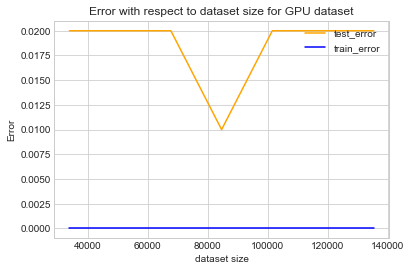

<Figure size 720x720 with 0 Axes>

In [63]:
train_error = np.array([0, 0,0,0,0])
test_error = np.array([0.02, 0.02, 0.01, 0.02, 0.02])
dataset_size = np.array([33824, 67648, 84560, 101472, 135296])

plt.style.use('seaborn-whitegrid')
plt.plot(dataset_size, test_error, color = 'orange')
plt.plot(dataset_size, train_error, color = 'blue')
plt.title("Error with respect to dataset size for GPU dataset")
plt.legend(["test_error", "train_error"], loc = 'upper right')
plt.ylabel("Error")
plt.xlabel("dataset size")
plt.figure(figsize = (10,10))

In [43]:
GBC_sp_1 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
GBC_sp_1.fit(spamdata_train_X, spamdata_train_Y)

print("train accuracy: ", GBC_sp_1.score(spamdata_train_X, spamdata_train_Y))
print("test accuracy: ", GBC_sp_1.score(spamdata_test_X, spamdata_test_Y))

train accuracy:  0.9661490683229814
test accuracy:  0.9485879797248371


In [47]:
from sklearn.model_selection import GridSearchCV
param_grid_sp = { 'n_estimators' : [20, 40, 60, 80,100], 'learning_rate': [0.1, 0.02, 0.005, 0.5]}
grid_sp = GridSearchCV(GradientBoostingClassifier(max_depth = 10, min_samples_leaf=50,max_features='sqrt'),param_grid_sp,refit=True,verbose=2, cv = 5)
grid_sp.fit(spamdata_train_X, spamdata_train_Y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] learning_rate=0.1, n_estimators=20 ..............................
[CV] ............... learning_rate=0.1, n_estimators=20, total=   0.1s
[CV] learning_rate=0.1, n_estimators=20 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............... learning_rate=0.1, n_estimators=20, total=   0.1s
[CV] learning_rate=0.1, n_estimators=20 ..............................
[CV] ............... learning_rate=0.1, n_estimators=20, total=   0.1s
[CV] learning_rate=0.1, n_estimators=20 ..............................
[CV] ............... learning_rate=0.1, n_estimators=20, total=   0.1s
[CV] learning_rate=0.1, n_estimators=20 ..............................
[CV] ............... learning_rate=0.1, n_estimators=20, total=   0.1s
[CV] learning_rate=0.1, n_estimators=40 ..............................
[CV] ............... learning_rate=0.1, n_estimators=40, total=   0.2s
[CV] learning_rate=0.1, n_estimators=40 ..............................
[CV] ............... learning_rate=0.1, n_estimators=40, total=   0.2s
[CV] learning_rate=0.1, n_estimators=40 ..............................
[CV] ............... learning_rate=0.1, n_estimators=40, total=   0.2s
[CV] learning_rate=0.1, n_estimators=40 ..............................
[CV] .

[CV] ............. learning_rate=0.005, n_estimators=40, total=   0.2s
[CV] learning_rate=0.005, n_estimators=60 ............................
[CV] ............. learning_rate=0.005, n_estimators=60, total=   0.3s
[CV] learning_rate=0.005, n_estimators=60 ............................
[CV] ............. learning_rate=0.005, n_estimators=60, total=   0.3s
[CV] learning_rate=0.005, n_estimators=60 ............................
[CV] ............. learning_rate=0.005, n_estimators=60, total=   0.3s
[CV] learning_rate=0.005, n_estimators=60 ............................
[CV] ............. learning_rate=0.005, n_estimators=60, total=   0.3s
[CV] learning_rate=0.005, n_estimators=60 ............................
[CV] ............. learning_rate=0.005, n_estimators=60, total=   0.3s
[CV] learning_rate=0.005, n_estimators=80 ............................
[CV] ............. learning_rate=0.005, n_estimators=80, total=   0.4s
[CV] learning_rate=0.005, n_estimators=80 ............................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   29.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=10,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=50,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  pres

In [48]:
print("Optimal parameters for the model are: ", grid_sp.best_estimator_)

Optimal parameters for the model are:  GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=50, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [49]:
param_grid_sp = { 'max_depth' : [5,10,15,20], 'min_samples_split': [10,30,50,60,100]}
grid_sp_2 = GridSearchCV(GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100,max_features='sqrt'),param_grid_sp,refit=True,verbose=2, cv = 5)
grid_sp_2.fit(spamdata_train_X, spamdata_train_Y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] max_depth=5, min_samples_split=10 ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ max_depth=5, min_samples_split=10, total=   0.3s
[CV] max_depth=5, min_samples_split=10 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ................ max_depth=5, min_samples_split=10, total=   0.3s
[CV] max_depth=5, min_samples_split=10 ...............................
[CV] ................ max_depth=5, min_samples_split=10, total=   0.3s
[CV] max_depth=5, min_samples_split=10 ...............................
[CV] ................ max_depth=5, min_samples_split=10, total=   0.3s
[CV] max_depth=5, min_samples_split=10 ...............................
[CV] ................ max_depth=5, min_samples_split=10, total=   0.3s
[CV] max_depth=5, min_samples_split=30 ...............................
[CV] ................ max_depth=5, min_samples_split=30, total=   0.3s
[CV] max_depth=5, min_samples_split=30 ...............................
[CV] ................ max_depth=5, min_samples_split=30, total=   0.3s
[CV] max_depth=5, min_samples_split=30 ...............................
[CV] ................ max_depth=5, min_samples_split=30, total=   0.3s
[CV] max_depth=5, min_samples_split=30 ...............................
[CV] .

[CV] ............... max_depth=15, min_samples_split=30, total=   1.4s
[CV] max_depth=15, min_samples_split=50 ..............................
[CV] ............... max_depth=15, min_samples_split=50, total=   1.0s
[CV] max_depth=15, min_samples_split=50 ..............................
[CV] ............... max_depth=15, min_samples_split=50, total=   1.0s
[CV] max_depth=15, min_samples_split=50 ..............................
[CV] ............... max_depth=15, min_samples_split=50, total=   1.0s
[CV] max_depth=15, min_samples_split=50 ..............................
[CV] ............... max_depth=15, min_samples_split=50, total=   1.0s
[CV] max_depth=15, min_samples_split=50 ..............................
[CV] ............... max_depth=15, min_samples_split=50, total=   0.9s
[CV] max_depth=15, min_samples_split=60 ..............................
[CV] ............... max_depth=15, min_samples_split=60, total=   1.1s
[CV] max_depth=15, min_samples_split=60 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presor

In [50]:
print("Optimal parameters for the model are: ", grid_sp_2.best_estimator_)

Optimal parameters for the model are:  GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=15,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=30,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


#### The best hyper parameters for the spambase dataset are learning rate = 0.1, n_estimators = 100, max_depth = 15, min_sample_split = 30

In [51]:
GBC_sp_2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=15, min_samples_split = 30)
GBC_sp_2.fit(spamdata_train_X, spamdata_train_Y)

print("train accuracy: ", GBC_sp_2.score(spamdata_train_X, spamdata_train_Y))
print("test accuracy: ", GBC_sp_2.score(spamdata_test_X, spamdata_test_Y))

train accuracy:  0.9996894409937889
test accuracy:  0.9543808834178131


In [55]:
GBC_sp_2.fit(sp_2_X, sp_2_Y)
print("train accuracy 20% data: ", GBC_sp_2.score(sp_2_X, sp_2_Y))
print("test accuracy: ", GBC_sp_2.score(spamdata_test_X, spamdata_test_Y))

GBC_sp_2.fit(sp_4_X, sp_4_Y)
print("train accuracy 40% data: ", GBC_sp_2.score(sp_4_X, sp_4_Y))
print("test accuracy: ", GBC_sp_2.score(spamdata_test_X, spamdata_test_Y))

GBC_sp_2.fit(sp_6_X, sp_6_Y)
print("train accuracy 60% data: ", GBC_sp_2.score(sp_6_X, sp_6_Y))
print("test accuracy: ", GBC_sp_2.score(spamdata_test_X, spamdata_test_Y))

GBC_sp_2.fit(sp_5_X, sp_5_Y)
print("train accuracy 50% data: ", GBC_sp_2.score(sp_5_X, sp_5_Y))
print("test accuracy: ", GBC_sp_2.score(spamdata_test_X, spamdata_test_Y))

GBC_sp_2.fit(sp_8_X, sp_8_Y)
print("train accuracy 80% data: ", GBC_sp_2.score(sp_8_X, sp_8_Y))
print("test accuracy: ", GBC_sp_2.score(spamdata_test_X, spamdata_test_Y))

train accuracy 20% data:  1.0
test accuracy:  0.9275887038377987
train accuracy 40% data:  1.0
test accuracy:  0.942795076031861
train accuracy 60% data:  1.0
test accuracy:  0.9478638667632151
train accuracy 50% data:  1.0
test accuracy:  0.9370021723388848
train accuracy 80% data:  1.0
test accuracy:  0.942070963070239


<Figure size 720x720 with 0 Axes>

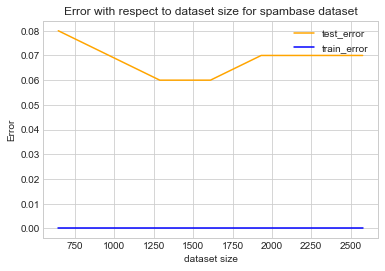

<Figure size 720x720 with 0 Axes>

In [64]:
train_error = np.array([0, 0,0,0,0])
test_error = np.array([0.08, 0.06, 0.06, 0.07, 0.07])
dataset_size = np.array([644, 1288, 1610, 1932, 2576])

plt.style.use('seaborn-whitegrid')
plt.plot(dataset_size, test_error, color = 'orange')
plt.plot(dataset_size, train_error, color = 'blue')
plt.title("Error with respect to dataset size for spambase dataset")
plt.legend(["test_error","train_error"], loc = 'upper right')
plt.ylabel("Error")
plt.xlabel("dataset size")
plt.figure(figsize = (10,10))

## SVM

### GPU data

In [ ]:
## Apart from the above mentioned dataset sizes we will also run on smaller datasets
## n = 5000 (c)
GPU_5000_X = GPU_train_X.sample(n = 5000, random_state = 33)
GPU_5000_Y = GPU_train_Y.sample(n = 5000, random_state = 33)
print("5000 data shape for X & Y = " ,GPU_5000_X.shape, GPU_5000_Y.shape)  
print("Value distribution for the class variable is: ") 
print (GPU_5000_Y.value_counts())

## n = 5 (d)
GPU_5_X = GPU_train_X.sample(n = 5, random_state = 66)
GPU_5_Y = GPU_train_Y.sample(n = 5, random_state = 66)
print("n=50 data shape for X & Y = " ,GPU_5_X.shape, GPU_5_Y.shape)  
print("Value distribution for the class variable is: ") 
print (GPU_5_Y.value_counts())

## n = 50 (e)
GPU_50_X = GPU_train_X.sample(n = 50, random_state = 77)
GPU_50_Y = GPU_train_Y.sample(n = 50, random_state = 77)
print("n=50 data shape for X & Y = " ,GPU_50_X.shape, GPU_50_Y.shape)  
print("Value distribution for the class variable is: ") 
print (GPU_50_Y.value_counts())

## n = 500 (f)
GPU_500_X = GPU_train_X.sample(n = 500, random_state = 88)
GPU_500_Y = GPU_train_Y.sample(n = 500, random_state = 88)
print("n=500 data shape for X & Y = " ,GPU_500_X.shape, GPU_500_Y.shape)  
print("Value distribution for the class variable is: ") 
print (GPU_500_Y.value_counts())

In [ ]:
## Simple SVC model without any hyperparameter tuning i.e C = 1
model_a = SVC(kernel='linear')
model_a.fit(GPU_2_X, GPU_2_Y)
predictions_a_test = model_a.predict(GPU_test_X) 
print("For test set:", classification_report(GPU_test_Y, predictions_a_test))
predictions_a_train = model_a.predict(GPU_2_X)
print("For train set:" ,classification_report(GPU_2_Y, predictions_a_train))

model_b = SVC(kernel='linear')
model_b.fit(GPU_4_X, GPU_4_Y)
predictions_b_test = model_a.predict(GPU_test_X) 
print("For test set:", classification_report(GPU_test_Y, predictions_b_test))
predictions_b_train = model_a.predict(GPU_4_X)
print("For train set:" ,classification_report(GPU_4_Y, predictions_b_train))

model_c = SVC(kernel='linear')
model_c.fit(GPU_5000_X, GPU_5000_Y)
predictions_c_test = model_c.predict(GPU_test_X) 
print("For test set:", classification_report(GPU_test_Y, predictions_c_test))
predictions_c_train = model_c.predict(GPU_5000_X)
print("For train set:" ,classification_report(GPU_5000_Y, predictions_c_train))

model_d = SVC(kernel='linear')
model_d.fit(GPU_5_X, GPU_5_Y)
predictions_d_test = model_d.predict(GPU_test_X) 
print("For test set:", classification_report(GPU_test_Y, predictions_d_test))
predictions_d_train = model_a.predict(GPU_5_X)
print("For train set:" ,classification_report(GPU_5_Y, predictions_d_train))

model_e = SVC(kernel='linear')
model_e.fit(GPU_50_X, GPU_50_Y)
predictions_e_test = model_e.predict(GPU_test_X) 
print("For test set:", classification_report(GPU_test_Y, predictions_e_test))
predictions_e_train = model_e.predict(GPU_50_X)
print("For train set:" ,classification_report(GPU_50_Y, predictions_e_train))

model_f = SVC(kernel='linear')
model_f.fit(GPU_500_X, GPU_500_Y)
predictions_f_test = model_f.predict(GPU_test_X) 
print("For test set:", classification_report(GPU_test_Y, predictions_f_test))
predictions_f_train = model_f.predict(GPU_500_X)
print("For train set:" ,classification_report(GPU_500_Y, predictions_f_train))

model_g = SVC(kernel='linear')
model_g.fit(GPU_6_X, GPU_6_Y)
predictions_g_test = model_g.predict(GPU_test_X) 
print("For test set:", classification_report(GPU_test_Y, predictions_g_test))
predictions_g_train = model_g.predict(GPU_6_X)
print("For train set:" ,classification_report(GPU_6_Y, predictions_g_train))

model_h = SVC(kernel='linear')
model_h.fit(GPU_8_X, GPU_8_Y)
predictions_h_test = model_h.predict(GPU_test_X) 
print("For test set:", classification_report(GPU_test_Y, predictions_h_test))
predictions_h_train = model_h.predict(GPU_8_X)
print("For train set:" ,classification_report(GPU_8_Y, predictions_h_train))

<Figure size 720x720 with 0 Axes>

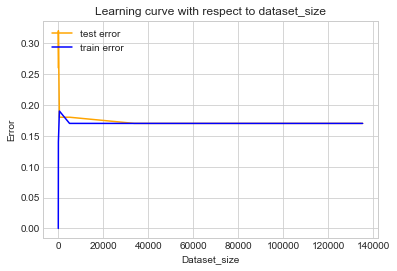

<Figure size 720x720 with 0 Axes>

In [13]:
test_error = np.array([0.26, 0.32, 0.18, 0.18, 0.17, 0.17, 0.17, 0.17])
train_error = np.array([0, 0.14, 0.19, 0.17, 0.17, 0.17, 0.17, 0.17])
dataset_size = np.array([5, 50, 500, 5000, 33824, 67648, 101472, 135296])

plt.style.use('seaborn-whitegrid')
plt.plot(dataset_size, test_error, color = 'orange')
plt.plot(dataset_size, train_error, color = 'blue')
plt.title("Learning curve with respect to dataset_size")
plt.legend(['test error', 'train error'], loc='upper left')
plt.ylabel("Error")
plt.xlabel("Dataset_size")
plt.figure(figsize = (10,10))

In [ ]:
### RBF
model_rbf_1 = SVC(kernel = 'rbf', random_state = 1, gamma = 0.1, C = 1) ## gamma = 0.1
model_rbf_1.fit(GPU_train_X, GPU_train_Y_1)
predictions_test_1 = model_rbf_1.predict(GPU_test_X)
print("Test Set: ", classification_report(GPU_test_Y, predictions_test_1))
predictions_train_1 = model_rbf_1.predict(GPU_train_X)
print("Train Set: ", classification_report(GPU_train_Y, predictions_train_1))

model_rbf_2 = SVC(kernel = 'rbf', random_state = 1, gamma = 0.01, C = 1) ## gamma = 0.01
model_rbf_2.fit(GPU_train_X, GPU_train_Y)
predictions_test_2 = model_rbf_1.predict(GPU_test_X)
print("Test Set: ", classification_report(GPU_test_Y, predictions_test_2))
predictions_train_2 = model_rbf_1.predict(GPU_train_X)
print("Train Set: ", classification_report(GPU_train_Y, predictions_train_2))

model_rbf_3 = SVC(kernel = 'rbf', random_state = 1, gamma = 0.0001, C = 1) ## gamma = 0.0001
model_rbf_3.fit(GPU_train_X, GPU_train_Y)
predictions_test_3 = model_rbf_1.predict(GPU_test_X)
print("Test Set: ", classification_report(GPU_test_Y, predictions_test_3))
predictions_train_3 = model_rbf_1.predict(GPU_train_X)
print("Train Set: ", classification_report(GPU_train_Y, predictions_train_3))

model_rbf_4 = SVC(kernel = 'rbf', random_state = 1, gamma = 10, C = 1)  ## gamma = 10
model_rbf_1.fit(GPU_train_X, GPU_train_Y)
predictions_test_4 = model_rbf_1.predict(GPU_test_X)
print("Test Set: ", classification_report(GPU_test_Y, predictions_test_4))
predictions_train_4 = model_rbf_1.predict(GPU_train_X)
print("Train Set: ", classification_report(GPU_train_Y, predictions_train_4))

model_rbf_5 = SVC(kernel = 'rbf', random_state = 1, gamma = 1000, C = 1) ## gamma = 1000
model_rbf_5.fit(GPU_train_X, GPU_train_Y)
predictions_test_5 = model_rbf_1.predict(GPU_test_X)
print("Test Set: ", classification_report(GPU_test_Y, predictions_test_5))
predictions_train_5 = model_rbf_1.predict(GPU_train_X)
print("Train Set: ", classification_report(GPU_train_Y, predictions_train_5))

## Varying C
model_rbf_1 = SVC(kernel = 'rbf', random_state = 1, gamma = 0.1, C = 0.1) ## C = 0.1
model_rbf_1.fit(GPU_train_X, GPU_train_Y)
predictions_test_1 = model_rbf_1.predict(GPU_test_X)
print("Test Set: ", classification_report(GPU_test_Y, predictions_test_1))
predictions_train_1 = model_rbf_1.predict(GPU_train_X)
print("Train Set: ", classification_report(GPU_train_Y, predictions_train_1))

model_rbf_6 = SVC(kernel = 'rbf', random_state = 1, gamma = 0.1, C = 0.01) ## C = 0.01
model_rbf_6.fit(GPU_train_X, GPU_train_Y)
predictions_test_6 = model_rbf_6.predict(GPU_test_X)
print("Test Set: ", classification_report(GPU_test_Y, predictions_test_6))
predictions_train_6 = model_rbf_6.predict(GPU_train_X)
print("Train Set: ", classification_report(GPU_train_Y, predictions_train_6))

model_rbf_7 = SVC(kernel = 'rbf', random_state = 1, gamma = 0.1, C = 10) ## C = 10
model_rbf_7.fit(GPU_train_X, GPU_train_Y)
predictions_test_7 = model_rbf_1.predict(GPU_test_X)
print("Test Set: ", classification_report(GPU_test_Y, predictions_test_7))
predictions_train_7 = model_rbf_1.predict(GPU_train_X)
print("Train Set: ", classification_report(GPU_train_Y, predictions_train_7))

model_rbf_8 = SVC(kernel = 'rbf', random_state = 1, gamma = 0.1, C = 100) ## C = 100
model_rbf_8.fit(GPU_train_X, GPU_train_Y)
predictions_test_8 = model_rbf_1.predict(GPU_test_X)
print("Test Set: ", classification_report(GPU_test_Y, predictions_test_8))
predictions_train_8 = model_rbf_1.predict(GPU_train_X)
print("Train Set: ", classification_report(GPU_train_Y, predictions_train_8))

<Figure size 72x72 with 0 Axes>

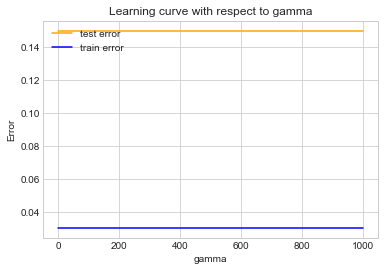

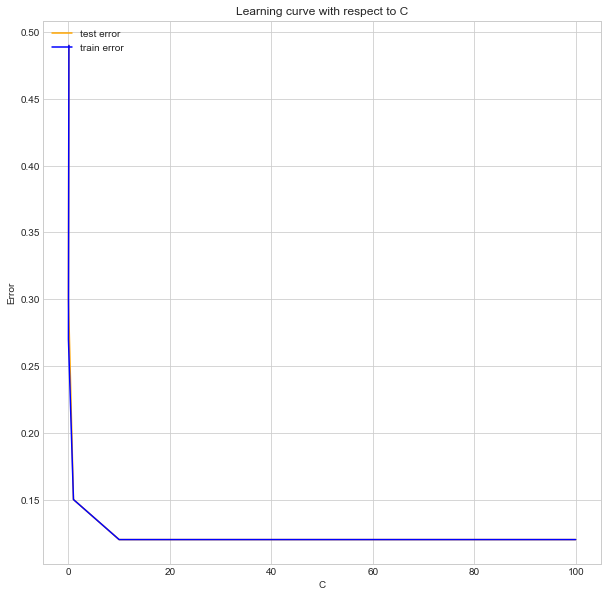

<Figure size 72x72 with 0 Axes>

In [16]:
gamma = np.array([0.0001, 0.01, 0.1, 10, 1000])
test_error = np.array([0.15,0.15,0.15,0.15,0.15])
train_error = np.array([0.03,0.03,0.03,0.03,0.03])
C = np.array([0.1, 0.01, 1, 10, 100])
test_error_C = np.array([0.49, 0.30, 0.15, 0.12, 0.12])
train_error_C = np.array([0.49, 0.27, 0.15, 0.12, 0.12])

plt.style.use('seaborn-whitegrid')
plt.plot(gamma, test_error, color = 'orange')
plt.plot(gamma, train_error, color = 'blue')
plt.title("Learning curve with respect to gamma")
plt.legend(['test error', 'train error'], loc='upper left')
plt.ylabel("Error")
plt.xlabel("gamma")
plt.figure(figsize = (10,10))

plt.style.use('seaborn-whitegrid')
plt.plot(C, test_error_C, color = 'orange')
plt.plot(C, train_error_C, color = 'blue')
plt.title("Learning curve with respect to C")
plt.legend(['test error', 'train error'], loc='upper left')
plt.ylabel("Error")
plt.xlabel("C")
plt.figure(figsize = (1,1))

In [ ]:
### Importing grid search
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001, 0.0001],'kernel': ['rbf']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(GPU_train_X, GPU_train_Y)

print("Optimal parameters for the model are: ", grid.best_estimator_)

grid_predictions = grid.predict(GPU_test_X)
print(confusion_matrix(GPU_test_Y,grid_predictions))
print(classification_report(GPU_test_Y,grid_predictions))
print(accuracy_score(GPU_test_Y,grid_predictions))

### spambase data

In [126]:
## Simple SVC model without any hyperparameter tuning i.e C = 1
SVM_sp_1 = SVC(kernel='linear')
SVM_sp_1.fit(spamdata_train_X, spamdata_train_Y)

predictions_sp_test_1 = SVM_sp_1.predict(spamdata_test_X) 
print("For test set:", classification_report(spamdata_test_Y, predictions_sp_test_1))

predictions_sp_train_1 = SVM_sp_1.predict(spamdata_train_X)
print("For train set:" ,classification_report(spamdata_train_Y, predictions_sp_train_1))

For test set:               precision    recall  f1-score   support

           0       0.94      0.96      0.95       822
           1       0.94      0.91      0.92       559

    accuracy                           0.94      1381
   macro avg       0.94      0.93      0.94      1381
weighted avg       0.94      0.94      0.94      1381

For train set:               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1966
           1       0.93      0.90      0.91      1254

    accuracy                           0.93      3220
   macro avg       0.93      0.93      0.93      3220
weighted avg       0.93      0.93      0.93      3220



In [53]:
## Varying size of the train dataset and determining the accuracy of the model
## 20% data 
sp_2_X = spamdata_train_X.sample(frac = 0.2, random_state = 11)
sp_2_Y = spamdata_train_Y.sample(frac = 0.2, random_state = 11)


## 40% data
sp_4_X = spamdata_train_X.sample(frac = 0.4, random_state = 22)
sp_4_Y = spamdata_train_Y.sample(frac = 0.4, random_state = 22)

## 50% data
sp_5_X = spamdata_train_X.sample(frac = 0.5, random_state = 66)
sp_5_Y = spamdata_train_Y.sample(frac = 0.5, random_state = 66)

## 60% data
sp_6_X = spamdata_train_X.sample(frac = 0.6, random_state = 88)
sp_6_Y = spamdata_train_Y.sample(frac = 0.6, random_state = 88)

## 80% data 
sp_8_X = spamdata_train_X.sample(frac = 0.8, random_state = 100)
sp_8_Y = spamdata_train_Y.sample(frac = 0.8, random_state = 100)

In [129]:
SVM_sp_2 = SVC(kernel='linear')
SVM_sp_2.fit(sp_2_X, sp_2_Y)

predictions_sp_test_2 = SVM_sp_2.predict(spamdata_test_X) 
print("For test set:", classification_report(spamdata_test_Y, predictions_sp_test_2))

predictions_sp_train_2 = SVM_sp_2.predict(sp_2_X)
print("For train set:" ,classification_report(sp_2_Y, predictions_sp_train_2))

SVM_sp_4 = SVC(kernel='linear')
SVM_sp_4.fit(sp_4_X, sp_4_Y)

predictions_sp_test_4 = SVM_sp_4.predict(spamdata_test_X) 
print("For test set:", classification_report(spamdata_test_Y, predictions_sp_test_4))

predictions_sp_train_4 = SVM_sp_4.predict(sp_4_X)
print("For train set:" ,classification_report(sp_4_Y, predictions_sp_train_4))

For test set:               precision    recall  f1-score   support

           0       0.92      0.94      0.93       822
           1       0.91      0.88      0.89       559

    accuracy                           0.92      1381
   macro avg       0.92      0.91      0.91      1381
weighted avg       0.92      0.92      0.92      1381

For train set:               precision    recall  f1-score   support

           0       0.95      0.95      0.95       401
           1       0.92      0.91      0.91       243

    accuracy                           0.93       644
   macro avg       0.93      0.93      0.93       644
weighted avg       0.93      0.93      0.93       644

For test set:               precision    recall  f1-score   support

           0       0.93      0.96      0.95       822
           1       0.94      0.90      0.92       559

    accuracy                           0.94      1381
   macro avg       0.94      0.93      0.93      1381
weighted avg       0.94      0.

In [130]:
SVM_sp_6 = SVC(kernel='linear')
SVM_sp_6.fit(sp_6_X, sp_6_Y)

predictions_sp_test_6 = SVM_sp_6.predict(spamdata_test_X) 
print("For test set:", classification_report(spamdata_test_Y, predictions_sp_test_6))

predictions_sp_train_6 = SVM_sp_6.predict(sp_6_X)
print("For train set:" ,classification_report(sp_6_Y, predictions_sp_train_6))

SVM_sp_5 = SVC(kernel='linear')
SVM_sp_5.fit(sp_5_X, sp_5_Y)

predictions_sp_test_5 = SVM_sp_5.predict(spamdata_test_X) 
print("For test set:", classification_report(spamdata_test_Y, predictions_sp_test_5))

predictions_sp_train_5 = SVM_sp_4.predict(sp_5_X)
print("For train set:" ,classification_report(sp_5_Y, predictions_sp_train_5))

SVM_sp_8 = SVC(kernel='linear')
SVM_sp_8.fit(sp_8_X, sp_8_Y)

predictions_sp_test_8 = SVM_sp_8.predict(spamdata_test_X) 
print("For test set:", classification_report(spamdata_test_Y, predictions_sp_test_8))

predictions_sp_train_8 = SVM_sp_8.predict(sp_8_X)
print("For train set:" ,classification_report(sp_8_Y, predictions_sp_train_8))

For test set:               precision    recall  f1-score   support

           0       0.92      0.96      0.94       822
           1       0.94      0.88      0.91       559

    accuracy                           0.93      1381
   macro avg       0.93      0.92      0.93      1381
weighted avg       0.93      0.93      0.93      1381

For train set:               precision    recall  f1-score   support

           0       0.94      0.95      0.95      1177
           1       0.93      0.90      0.91       755

    accuracy                           0.93      1932
   macro avg       0.93      0.93      0.93      1932
weighted avg       0.93      0.93      0.93      1932

For test set:               precision    recall  f1-score   support

           0       0.93      0.96      0.94       822
           1       0.93      0.89      0.91       559

    accuracy                           0.93      1381
   macro avg       0.93      0.92      0.93      1381
weighted avg       0.93      0.

In [133]:
sp_rbf_1 = SVC(kernel = 'rbf', random_state = 1, gamma = 0.1, C = 1)
sp_rbf_1.fit(spamdata_train_X, spamdata_train_Y)
pred_test_1 = sp_rbf_1.predict(spamdata_test_X)
print("Test Set: ", classification_report(spamdata_test_Y, pred_test_1))
pred_train_1 = sp_rbf_1.predict(spamdata_train_X)
print("Train Set: ", classification_report(spamdata_train_Y, pred_train_1))


Test Set:                precision    recall  f1-score   support

           0       0.73      0.96      0.83       822
           1       0.90      0.49      0.63       559

    accuracy                           0.77      1381
   macro avg       0.82      0.73      0.73      1381
weighted avg       0.80      0.77      0.75      1381

Train Set:                precision    recall  f1-score   support

           0       0.98      1.00      0.99      1966
           1       1.00      0.97      0.99      1254

    accuracy                           0.99      3220
   macro avg       0.99      0.99      0.99      3220
weighted avg       0.99      0.99      0.99      3220



In [134]:
### Importing grid search
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001, 0.0001],'kernel': ['rbf']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(spamdata_train_X, spamdata_train_Y)

/Users/Sujatha/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.6s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.6s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.8s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.6s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.6s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.6s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=0.1, gamma=0.01, kernel=rbf, total=   0.5s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=0.1, gamma=0.01, kernel=rbf, total=   0.5s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .

[CV] .................. C=100, gamma=0.0001, kernel=rbf, total=   0.4s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ...................... C=1000, gamma=1, kernel=rbf, total=   0.6s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ...................... C=1000, gamma=1, kernel=rbf, total=   0.6s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ...................... C=1000, gamma=1, kernel=rbf, total=   0.6s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] .................... C=1000, gamma=0.1, kernel=rbf, total=   0.6s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] .................... C=1000, gamma=0.1, kernel=rbf, total=   0.6s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] .................... C=1000, gamma=0.1, kernel=rbf, total=   0.6s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   43.0s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [135]:
print("Optimal parameters for the model are: ", grid.best_estimator_)

Optimal parameters for the model are:  SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [136]:
sp_rbf_2 = SVC(kernel = 'rbf', gamma = 0.0001, C = 1000)
sp_rbf_2.fit(spamdata_train_X, spamdata_train_Y)

pred_test_2 = sp_rbf_2.predict(spamdata_test_X)
print("Test Set: ", classification_report(spamdata_test_Y, pred_test_2))

pred_train_2 = sp_rbf_2.predict(spamdata_train_X)
print("Train Set: ", classification_report(spamdata_train_Y, pred_train_2))

Test Set:                precision    recall  f1-score   support

           0       0.93      0.95      0.94       822
           1       0.92      0.90      0.91       559

    accuracy                           0.93      1381
   macro avg       0.93      0.92      0.93      1381
weighted avg       0.93      0.93      0.93      1381

Train Set:                precision    recall  f1-score   support

           0       0.96      0.97      0.97      1966
           1       0.95      0.94      0.95      1254

    accuracy                           0.96      3220
   macro avg       0.96      0.95      0.96      3220
weighted avg       0.96      0.96      0.96      3220



In [ ]:
sp_poly_1 = SVC(kernel = 'poly', gamma = 0.1, C = 1)
sp_poly_1.fit(spamdata_train_X, spamdata_train_Y)

poly_pred_test_1 = sp_poly_1.predict(spamdata_test_X)
print("Test Set: ", classification_report(spamdata_test_Y, poly_pred_test_1))

poly_pred_train_1 = sp_poly_1.predict(spamdata_train_X)
print("Train Set: ", classification_report(spamdata_train_Y, poly_pred_train_1))